In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
import torch
import torch.nn as nn

class SSLayer(nn.Module):
    def __init__(self, n_x, n_u, n_y):
        super(SSLayer, self).__init__()
        self.n_x, self.n_u, self.n_y = n_x, n_u, n_y
        self.init_parameters()
    
    def init_parameters(self):
        # Initialize parameters
        self.mu = nn.Parameter(torch.randn(self.n_x))  # (n_x) diagonal of A
        self.theta = nn.Parameter(torch.randn(self.n_x))  # (n_x)
        self.B_norm = nn.Parameter(torch.randn(self.n_x, self.n_u))  #(n_x, n_u)
        self.C = nn.Parameter(torch.randn(self.n_y, self.n_x))  #  (n_y, n_x)
        self.D = nn.Parameter(torch.randn(self.n_y, self.n_u))  #  (n_y, n_u)
        self.F = nn.Parameter(torch.eye(self.n_y, self.n_u))  #  (n_y, n_u)
        
        # Normalize B
        self.normalize_B()
    
    def normalize_B(self):
        lambdas = torch.exp(-torch.exp(self.mu) + 1j * self.theta)  # EV of A
        gamma = torch.sqrt(1 - torch.abs(lambdas)**2).view(-1, 1)  # Shape: (n_x, 1)
        self.B = nn.Parameter(gamma * self.B_norm)  # Shape: (n_x, n_u)
    
    def forward(self, u):
        batch_size, time_steps, _ = u.size()

        # Initialize hidden state
        x = torch.zeros(batch_size, self.n_x, dtype=torch.complex64, device=u.device).transpose(0, 1)

        outputs = []

        # Matrix A computed from parameters (complex)
        A = torch.diag_embed(torch.exp(-torch.exp(self.mu) + 1j * self.theta))  # (n_x, n_x)
        for t in range(time_steps):  # Iterate over time steps
            u_t = u[:, t, :].to(torch.complex64).transpose(0, 1)  # (n_u, batch_size)
            
            """ # Debugging shapes before operations
            print(f"Step {t}")
            print(f"A shape: {A.shape}")  # (4, 4)
            print(f"x shape: {x.shape}")  # (batch_size, 4)
            print(f"self.B shape: {self.B.shape}")  # (4, batch_size)
            print(f"u_t shape: {u_t.shape}")  # (batch_size, 5)"""
            
            # Compute next state and output
            x_next = A @ x + self.B.to(torch.complex64) @ u_t
            eta = self.C.to(torch.complex64) @ x_next + self.D.to(torch.complex64) @ u_t
            output = torch.tanh(eta) + self.F.to(torch.complex64) @ u_t

            outputs.append(output)
            x = x_next            
            
        
        return torch.stack(outputs, dim=1)

class SSM(nn.Module):
    def __init__(self, n_layers, n_x, n_u, n_y):
        super(SSM, self).__init__()
        
        self.first_layer = SSLayer(n_x, n_u, n_y)
        self.other_layers = nn.ModuleList([
            SSLayer(n_x, n_y, n_y) for _ in range(1, n_layers)
        ])
        #  train for first layer and other layers matrices (different sizes because different output sizes...)

    def forward(self, u):
        # Pass input to the first layer
        output = self.first_layer(u)
        #print(output.shape)

        # Pass output to the other layers
        for layer in self.other_layers:
            output = output.transpose(0, 2)  # adjust dimensions
            output = layer(output)

        return output

# init model
n_layers, n_x, n_u, n_y = 2, 4, 3, 2
model = SSM(n_layers, n_x, n_u, n_y)


In [3]:
# Import necessary libraries
from src.models import LSTModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn 
import scipy.signal as signal


# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(torch.cuda.is_available())
device = torch.device("cpu")

# Close all open plots
plt.close('all')
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_.mat')
data_out = scipy.io.loadmat(filepath)


# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
    
nExp = yExp.size
# Create time vector
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 3)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = 2

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
            (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp
            torch.from_numpy(buildtot[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot
            dim=-1
        )    
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 15))            # to smooth the input signal of Qhot (noisy)

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

print(u.shape)
print(y.shape)

torch.Size([5, 30240, 3])
torch.Size([5, 30240, 2])


In [4]:
# Example training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epochs = 600
# Load the model parameters before starting a new training session
#model.load_state_dict(torch.load('parameters_SSM_Qdirect.pth'))
# Initialize array to store loss values
LOSS = np.zeros(epochs)

print("Input tensor shape:", u.shape)  # Should print (batch_size, time_steps, n_u)
# Assume u_train and y_train are your input and target sequences
for epoch in range(epochs):
# Adjust learning rate at certain epochs
    if epoch == epochs - epochs // 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if epoch == epochs - epochs // 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    y_pred = model(u)
    loss = criterion(y_pred.real, y.transpose(0,2))
    loss.backward()
    optimizer.step()
    LOSS[epoch] = loss.item()
    print(f"Epoch {epoch}, Loss: {loss.item()}")


Input tensor shape: torch.Size([5, 30240, 3])
Epoch 0, Loss: 0.35077130794525146
Epoch 1, Loss: 0.2775942385196686
Epoch 2, Loss: 0.23006603121757507
Epoch 3, Loss: 0.19952408969402313
Epoch 4, Loss: 0.18121401965618134
Epoch 5, Loss: 0.16972726583480835
Epoch 6, Loss: 0.16290059685707092
Epoch 7, Loss: 0.158005028963089
Epoch 8, Loss: 0.15356187522411346
Epoch 9, Loss: 0.14871157705783844
Epoch 10, Loss: 0.1432717889547348
Epoch 11, Loss: 0.13770049810409546
Epoch 12, Loss: 0.1324206292629242
Epoch 13, Loss: 0.12761186063289642
Epoch 14, Loss: 0.12502875924110413
Epoch 15, Loss: 0.12179028987884521
Epoch 16, Loss: 0.11744489520788193
Epoch 17, Loss: 0.11426080763339996
Epoch 18, Loss: 0.11134380847215652
Epoch 19, Loss: 0.10784807801246643
Epoch 20, Loss: 0.10459274053573608
Epoch 21, Loss: 0.10140954703092575
Epoch 22, Loss: 0.09842930734157562
Epoch 23, Loss: 0.09570778906345367
Epoch 24, Loss: 0.09325283020734787
Epoch 25, Loss: 0.09103293716907501
Epoch 26, Loss: 0.089018747210502

In [5]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, 3)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
            (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 to 5
            torch.from_numpy(buildtot_val[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)), 
            dim=-1
        ) 
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 15))

# Get RNN output for validation data
ySSM_val = model(uval).transpose(0,2)
ySSM_val = ySSM_val#.unsqueeze_(0)

# Calculate loss for validation data
loss_val = criterion(ySSM_val.real, yval)

In [6]:
# Save the model parameters after training
torch.save(model.state_dict(), 'parameters_SSM_Qdirect.pth')

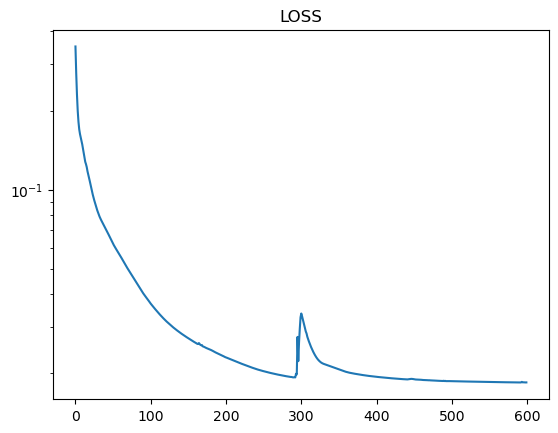

c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


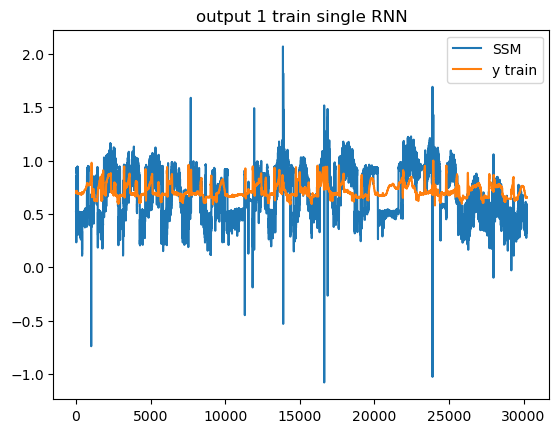

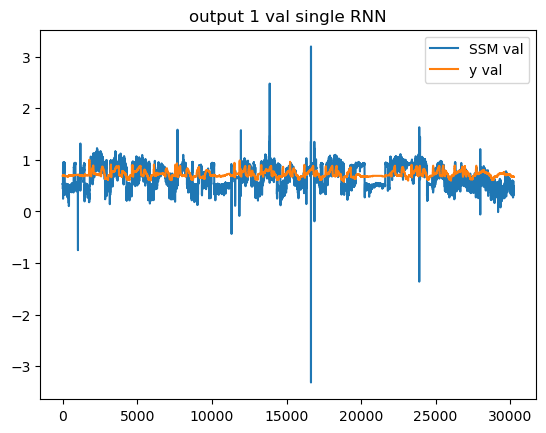

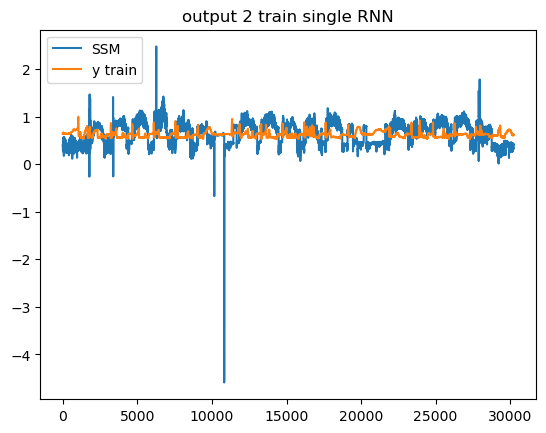

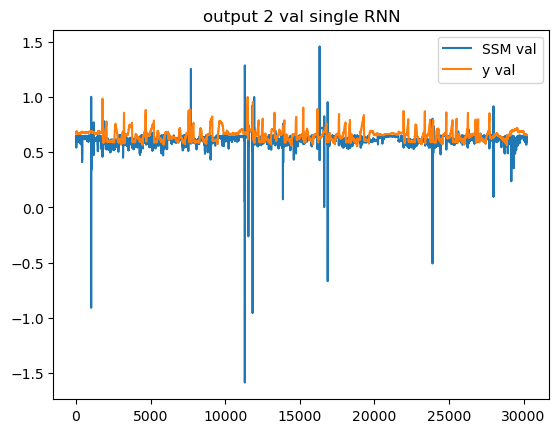

Loss Validation single RNN: 0.021581020206212997


In [7]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.yscale('log')
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(y_pred[0, 10:, 0].detach().numpy(), label='SSM')
plt.plot(y[0, 10:, 0].detach().numpy(), label='y train')
plt.title("output 1 train single RNN")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(ySSM_val[0, 10:, 0].detach().numpy(), label='SSM val')
plt.plot(yval[0, 10:, 0].detach().numpy(), label='y val')
plt.title("output 1 val single RNN")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(y_pred[0, 10:, 1].detach().numpy(), label='SSM')
plt.plot(y[0, 10:, 1].detach().numpy(), label='y train')
plt.title("output 2 train single RNN")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(ySSM_val[0, 10:, 1].detach().numpy(), label='SSM val')
plt.plot(yval[0, 10:, 1].detach().numpy(), label='y val')
plt.title("output 2 val single RNN")
plt.legend()
plt.show()

# Save RNN output and validation data to file
#scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single RNN: {loss_val}")